# Named Entity Recognition с нуля

## Зависимости

In [ ]:
!pip install pytorch_lightning ipdb transformers razdel ipymarkup slovnet natasha

In [ ]:
import ipdb
import os
import re
import random
import json
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import razdel
from razdel import tokenize
from collections import Counter, namedtuple
from enum import IntEnum



import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler
from torchmetrics.classification.accuracy import Accuracy

from pytorch_lightning import LightningModule
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping  
from transformers import XLMRobertaTokenizer, XLMRobertaModel

import xml.etree.ElementTree as ET
from ipymarkup import show_box_markup
from ipymarkup.palette import palette, BLUE, RED, GREEN

## Датасет
Новый день - новый датасет! 

http://ai-center.botik.ru/Airec/index.php/ru/collections/28-persons-1000

In [ ]:
!rm -f Persons-1000.zip
!wget -q http://ai-center.botik.ru/Airec/ai-resources/Persons-1000.zip
!unzip -qq Persons-1000.zip

In [ ]:
!head -100 Persons-1000/collection/001/anno.markup.xml  

﻿<markup>
<entry>
<id>1</id>
<offset>308</offset>
<length>16</length>
<class>AAA_Estimate_Person</class>
<attribute>
<name>Canonical</name>
<value>ГРИГОРИЙ КАРАСИН</value>
</attribute>
</entry>
<entry>
<id>2</id>
<offset>387</offset>
<length>15</length>
<class>AAA_Estimate_Person</class>
<attribute>
<name>Canonical</name>
<value>ДЭНИЭЛ ФРИД</value>
</attribute>
</entry>
</markup>


Named Entity Recognition - распознавание именных сущностей. Выделяем в тексте спаны PER, LOC, ORG.

В случае с Persons-1000 только PER. Считаем датасет из XML.

In [ ]:
directory = "Persons-1000/collection/"

def read_text_with_markup(directory):
    MARKUP_FILE_NAME = "anno.markup.xml"
    TEXT_FILE_NAME = "text.txt"
    ENCODING = "windows-1251"
    ENTRY_TAG = "entry"
    START_POS_TAG = "offset"
    LENGTH_TAG = "length"

    markup_file_name = os.path.join(directory, MARKUP_FILE_NAME)
    text_file_name = os.path.join(directory, TEXT_FILE_NAME)
    with open(text_file_name, "r", encoding=ENCODING) as r:
        text = r.read()
    text = text.replace("\n", "\r\n")
    
    root = ET.parse(markup_file_name).getroot()
    spans = []
    for entry in root.findall(ENTRY_TAG):
        start_pos = int(entry.find(START_POS_TAG).text)
        end_pos = start_pos + int(entry.find(LENGTH_TAG).text)
        spans.append((start_pos, end_pos, "PER"))
    return text, spans

data = []
for sample_name in os.listdir(directory):
    sample_path = os.path.join(directory, sample_name)
    data.append(read_text_with_markup(sample_path))

In [ ]:
data[0][1]

[(0, 10, 'PER'),
 (75, 91, 'PER'),
 (154, 171, 'PER'),
 (397, 413, 'PER'),
 (418, 428, 'PER'),
 (1332, 1354, 'PER'),
 (1470, 1480, 'PER'),
 (1636, 1646, 'PER')]

ipymarkup - модуль для вывода NER разметки в ipynb

In [ ]:
show_box_markup(data[0][0], data[0][1], palette=palette(PER=BLUE, ORG=RED, LOC=GREEN))

## BIO

BIO разметка: B - begin, I - inner, O - outer. Преобразуем задачу разметки спанов в задачу классификации каждого слова.

0 = O = outer, 1 = B = begin, 2 = I = inner

In [ ]:
class Label(IntEnum):
    OUTER = 0
    BEGIN = 1
    INNER = 2

Sample = namedtuple("Sample", "text,tokens,spans,labels")

def text_span_to_sample(text, spans):
    labels = []
    tokens = list(tokenize(text))
    for token in tokens:
        label = Label.OUTER
        for span in spans:
            # Начало или часть какого-то спана
            # Не совсем корректно из-за возможных различий разметки и токенизации
            span_begin, span_end, tag = span
            if token.start == span_begin:
                label = Label.BEGIN
            elif token.start > span_begin and token.stop <= span_end:
                label = Label.INNER
        labels.append(label)
    # Проверяем инвариант отсутствия последовательных пар (0, 2)
    assert len([1 for i in range(len(labels) - 1) if (labels[i], labels[i+1]) == (0, 2)]) == 0
    return Sample(text, tokens, spans, labels)

samples = []
for text, spans in data:
    samples.append(text_span_to_sample(text, spans))

show_box_markup(samples[2].text, samples[2].spans, palette=palette(PER=BLUE, ORG=RED, LOC=GREEN))
print(samples[2].labels)
print(len(samples))

[<Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.BEGIN: 1>, <Label.INNER: 2>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.BEGIN: 1>, <Label.INNER: 2>, <Label.INNER: 2>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OUTER: 0>, <Label.OU

Бьём на выборки

In [ ]:
random.shuffle(samples)

train = samples[:700]
val = samples[700:850]
test = samples[850:]

In [ ]:
char_set = ["<pad>", "<unk>"] + list({ch for sample in train for token in sample.tokens for ch in token.text})
print(char_set)

['<pad>', '<unk>', 'У', 'h', 'Д', 'з', 'k', 'Y', '$', 'S', 'к', 'П', '#', 'Z', 'a', 'R', '|', 'g', 'л', 'н', 'Я', 'ё', ']', 'А', '<', 'Ц', '—', 'в', 'O', 'i', 'X', 'M', '6', 'w', 'й', 'Ю', 'c', 'М', 'Ч', "'", '"', 'F', ',', '“', 'і', '№', '?', 's', 'ж', 'г', '-', 'Л', 'ц', 'L', 'Э', ')', 'Т', 'е', 'Ъ', '/', 'e', 'ъ', '\xad', 't', '«', '€', 'y', 'K', 'Е', '5', 'B', '…', 'v', 'э', 'З', '3', 'р', '>', 'z', 'б', '4', 'Х', 'N', 'q', 'Q', 'т', 'И', '•', 'n', '2', 'Ж', 'A', 'ю', 'Н', '_', '8', 'I', '–', 'Р', '&', 'p', 'P', 'я', '*', 'Ф', 'о', '0', 'Г', '[', 'U', ';', 'ф', '7', 'J', 'V', 'H', 'ь', 'К', 'o', 'В', 'Й', 'а', 'и', 'Ь', 'j', 'l', 'b', 'Ё', 'Б', 'E', 'п', '+', '(', '%', '”', 'Щ', '.', '!', 'u', 'ч', 'ш', '9', 'м', 'с', 'щ', 'ы', ':', 'у', 'C', 'T', 'G', 'r', 'W', 'D', 'f', 'д', 'd', '»', 'Ш', 'х', 'm', '©', 'x', 'Ы', '1', 'О', 'С']


Для каждого слова сохраняем его символьный состав, а в остальном старый добрый пайплайн

In [ ]:
sample = samples[0]

In [ ]:
max_seq_len = 0
max_char_seq_len = 0

for sample in samples:
  max_seq_len = max(len(sample.tokens), max_seq_len)
  for token in sample.tokens:
    max_char_seq_len = max(len(token.text), max_char_seq_len)

In [ ]:
max_seq_len

2005

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler

class NerCharsDataset(Dataset):
    def __init__(self, samples, char_set, max_seq_len=500, max_char_seq_len=50):
        assert len(samples) != 0
        self.samples = []
        self.tokens = []
        self.texts = []
        for sample in samples:
            inputs = torch.zeros((max_seq_len, max_char_seq_len), dtype=torch.long)
            for token_num, token in enumerate(sample.tokens[:max_seq_len]):
                for ch_num, ch in enumerate(token.text[:max_char_seq_len]):
                    char_index = char_set.index(ch) if ch in char_set else char_set.index("<unk>")
                    inputs[token_num][ch_num] = char_index
            labels = torch.zeros((max_seq_len), dtype=torch.long)
            input_labels = [int(i) for i in sample.labels[:max_seq_len]]
            labels[:len(input_labels)] = torch.LongTensor(input_labels)
            self.samples.append((torch.LongTensor(inputs), torch.LongTensor(labels)))
            self.tokens.append(sample.tokens[:max_seq_len])
            self.texts.append(sample.text)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        return self.samples[index]

    def get_tokens(self, index):
        return self.tokens[index]
    
    def get_text(self, index):
        return self.texts[index]


BATCH_SIZE = 32

train_data = NerCharsDataset(train, char_set)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

val_data = NerCharsDataset(val, char_set)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = NerCharsDataset(test, char_set)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
batch = next(iter(train_loader))

In [ ]:
inputs, labels = batch
print(inputs.size())
print(labels.size())

# inputs: batch_size x num_words x num_chars
# labels: batch_size x num_words

torch.Size([32, 500, 50])
torch.Size([32, 500])


In [ ]:
inputs[0]

tensor([[107, 147,  79,  ...,   0,   0,   0],
        [ 51,  57,  19,  ...,   0,   0,   0],
        [130, 105, 130,  ...,   0,   0,   0],
        ...,
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0],
        [  0,   0,   0,  ...,   0,   0,   0]])

In [ ]:
import torch
import torch.nn as nn
import torchmetrics
from pytorch_lightning import LightningModule
from torchmetrics import Accuracy
 

class TemplateModel(LightningModule):
    def __init__(self):
        super().__init__()
        
        self.loss = nn.CrossEntropyLoss()
        self.valid_accuracy = Accuracy(mdmc_reduce='samplewise')
        self.test_accuracy = Accuracy(mdmc_reduce='samplewise')
    
    def forward(self, inputs, labels):
        raise NotImplementedError("forward not implemented")
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        return [optimizer]
    
    def training_step(self, batch, _):
        inputs, labels = batch
        loss, logits = self(inputs, labels)
        return loss
    
    def validation_step(self, batch, _):
        inputs, labels = batch
        val_loss, logits = self(inputs, labels)
        self.valid_accuracy.update(logits, labels)
        self.log("val_loss", val_loss, prog_bar=True)
        self.log("val_acc", self.valid_accuracy)

    def validation_epoch_end(self, outs):
        self.log("val_acc_epoch", self.valid_accuracy.compute(), prog_bar=True)

    def test_step(self, batch, _):
        inputs, labels = batch
        test_loss, logits = self(inputs, labels)
        self.test_accuracy.update(logits, labels)
        self.log("test_loss", test_loss, prog_bar=True)
        self.log("test_acc", self.test_accuracy)

    def test_epoch_end(self, outs):
        self.log("test_acc_epoch", self.test_accuracy.compute(), prog_bar=True)

## Бесконтекстная модель

In [ ]:
DEVICE = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
DEVICE

device(type='cuda')

In [ ]:
import torch
from torch import nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

class SuperSimpleModel(TemplateModel):
    def __init__(self, char_set_size, char_embedding_dim=12, classes_count=3, char_max_seq_len=50):
        super().__init__()
        
        self.embeddings_layer = nn.Embedding(char_set_size, char_embedding_dim) # а -> [0.1, ... 0.3]
        self.out_layer = nn.Linear(char_max_seq_len * char_embedding_dim, classes_count)

    def forward(self, inputs, labels):
        #batch_size x seq_len x char_max_seq_len
        projections = self.embeddings_layer(inputs)
        #batch_size x seq_len x char_max_seq_len x char_embedding_dim
        projections = projections.reshape(projections.size(0), projections.size(1), -1) 
        #batch_size x seq_len x char_max_seq_len*char_embedding_dim
        logits = self.out_layer(projections)
        #batch_size x seq_len x 3
        logits = logits.transpose(1, 2)
        #batch_size x 3 x seq_len
        loss = self.loss(logits, labels)
        return loss, logits


super_simple_model = SuperSimpleModel(len(char_set))
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=5,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    accelerator='gpu',
    devices=1,
    accumulate_grad_batches=1,
    enable_checkpointing=False,
    max_epochs=150,
    enable_progress_bar=True,
    callbacks=[early_stop_callback])
trainer.fit(super_simple_model, train_loader, val_loader)
trainer.test(super_simple_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type             | Params
------------------------------------------------------
0 | loss             | CrossEntropyLoss | 0     
1 | valid_accuracy   | Accuracy         | 0     
2 | test_accuracy    | Accuracy         | 0     
3 | embeddings_layer | Embedding        | 2.0 K 
4 | out_layer        | Linear           | 1.8 K 
------------------------------------------------------
3.8 K     Trainable params
0         Non-trainable params
3.8 K     Total params
0.015     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.250


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.075 >= min_delta = 0.0001. New best score: 0.175


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.167


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.161


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.155


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.149


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.143


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.137


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.132


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.127


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.123


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.118


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.115


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.111


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.108


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.105


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.103


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.100


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.098


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.096


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.094


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.092


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.091


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.089


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.088


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.087


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.086


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.085


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.084


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.083


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.082


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.081


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.080


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.080


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.079


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.079


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.078


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.077


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.077


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.077


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.076


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.076


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.076


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.075


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.075


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.074


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.074


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.074


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.073


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.073


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.073


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.072


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.072


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.072


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.072


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.071


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.071


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.071


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.071


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.070


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.070


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.070


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.070


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.069


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.069


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 5 records. Best score: 0.069. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9726666212081909
     test_acc_epoch         0.9726666212081909
        test_loss           0.0734160915017128
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.0734160915017128,
  'test_acc': 0.9726666212081909,
  'test_acc_epoch': 0.9726666212081909}]

## Метрики

Можно использовать как классические мультиклассификационнные метрики, так и метрики специально для NER.

Например, число точных и частичных совпадений спанов, пропущенных и лишних спанов.

In [ ]:
inputs, true_labels = next(iter(train_loader))

In [ ]:
super_simple_model = super_simple_model.to(DEVICE)
_, logits = super_simple_model(inputs.to(DEVICE), true_labels.to(DEVICE))

In [ ]:
predicted_labels = logits.max(dim=1)[1].to(DEVICE)

In [ ]:
predicted_labels

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        ...,
        [1, 0, 2,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 0, 0],
        [2, 0, 0,  ..., 0, 0, 0]], device='cuda:0')

In [ ]:
def get_spans(labels, tokens):
    spans = []
    for i, (label, token) in enumerate(zip(labels, tokens)):
        if label == 1:
            spans.append((token.start, token.stop, "PER"))
        elif label == 2:
            assert len(spans) != 0, "Incorrect label sequence: {}".format(labels)
            old_begin, _, old_tag = spans[-1]
            spans[-1] = (old_begin, token.stop, old_tag)
    return spans


def compare_span_sets(left_spans, right_spans):
    exact, partial, missing = 0, 0, 0
    for left_span in left_spans:
        is_missing = True
        for right_span in right_spans:
            if left_span == right_span:
                exact += 1
                is_missing = False
                break
            ls, le, _ = left_span
            rs, re, _ = right_span
            # [ls le] [rs re]
            # [rs re] [ls le]
            if not (ls <= le <= rs <= re or rs <= re <= ls <= le):
                is_missing = False
                partial += 1
                break            
        if is_missing:
            missing += 1
    return exact, partial, missing


def calc_metrics(true_labels, predicted_labels, tokens):
    # Метрики классификации
    one_tp, one_fp, one_fn = 0, 0, 0
    for true, predicted in zip(true_labels, predicted_labels):
        for l1, l2 in zip(true, predicted):
            if l1 == 1 and l2 == 1:
                one_tp += 1
            elif l1 != 1 and l2 == 1:
                one_fp += 1
            elif l1 == 1 and l2 !=1:
                one_fn += 1
    if one_tp + one_fp == 0:
        print("No positives!")
    else:
        print("1 Precision: {}, 1 Recall: {}".format(float(one_tp)/(one_tp + one_fp), float(one_tp)/(one_tp + one_fn)))

    # Специализированные метрики
    e, p, m, s = 0, 0, 0, 0
    for (true, predicted), sample_tokens in zip(zip(true_labels, predicted_labels), tokens):
        true_spans = get_spans(true, sample_tokens)
        predicted_spans = get_spans(predicted, sample_tokens)
        exact, partial, missing = compare_span_sets(true_spans, predicted_spans)
        _, _, spurius = compare_span_sets(predicted_spans, true_spans)
        e += exact
        p += partial
        m += missing #fn
        s += spurius #fp
    print("Exact: {}, partial: {}, missing: {}, spurius: {}".format(e, p, m, s))
            


def predict(model, test_loader, show_sample_index=1):
    model.eval()
    all_true_labels, all_predicted_labels, all_tokens, all_texts = [], [], [], []
    for batch_index, batch in enumerate(test_loader):
        inputs, true_labels = batch
        batch_size = inputs.size(0)
        _, logits = model(inputs.to(DEVICE), true_labels.to(DEVICE))
        predicted_labels = logits.max(dim=1)[1].detach().cpu()

        # Убираем неконсистентность BIO
        for sample_num, sample in enumerate(predicted_labels):
            for token_num, label in enumerate(sample):
                if token_num == 0 and label == 2:
                    predicted_labels[sample_num][0] = 1
                    continue
                prev_label = sample[token_num - 1]
                if label == 2 and prev_label == 0:
                    predicted_labels[sample_num][token_num] = 1

        all_true_labels.extend(true_labels)
        all_predicted_labels.extend(predicted_labels)
        for i in range(batch_size):
            all_tokens.append(test_data.get_tokens(batch_index * batch_size + i))
            all_texts.append(test_data.get_text(batch_index * batch_size + i))

    calc_metrics(all_true_labels, all_predicted_labels, all_tokens)
    print("PREDICTED:")
    show_box_markup(all_texts[show_sample_index],
                    get_spans(all_predicted_labels[show_sample_index], all_tokens[show_sample_index]),
                    palette=palette(PER=BLUE, ORG=RED, LOC=GREEN))

In [ ]:
predict(super_simple_model, test_loader)

1 Precision: 0.5710643722115998, 1 Recall: 0.5894736842105263
Exact: 524, partial: 604, missing: 341, spurius: 245
PREDICTED:


## Контекстная модель: LSTM над конкатенацией

In [ ]:
class LstmModel(TemplateModel):
    def __init__(self, char_set_size, char_embedding_dim=4, classes_count=3,
                 lstm_embedding_dim=8, char_max_seq_len=50):
        super().__init__()
        
        self.embeddings_layer = nn.Embedding(char_set_size, char_embedding_dim)
        self.dropout = nn.Dropout(0.4)
        self.lstm_layer = nn.LSTM(char_embedding_dim * char_max_seq_len, lstm_embedding_dim // 2,
                                  batch_first=True, bidirectional=True)
        self.out_layer = nn.Linear(lstm_embedding_dim, classes_count)

    def forward(self, inputs, labels):
        #batch_size = inputs.size(0)
        #seq_len = inputs.size(1)
        projections = self.embeddings_layer(inputs)
        projections = projections.reshape(projections.size(0), projections.size(1), -1)
        output, _= self.lstm_layer(projections)
        output = self.dropout(output)
        logits = self.out_layer(output)
        logits = logits.transpose(1, 2)
        loss = self.loss(logits, labels)
        return loss, logits


lstm_model = LstmModel(len(char_set))
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=5,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    accelerator='gpu',
    devices=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1,
    max_epochs=150,
    enable_progress_bar=True,
    callbacks=[early_stop_callback])
trainer.fit(lstm_model.to(DEVICE), train_loader, val_loader)
trainer.test(lstm_model.to(DEVICE), test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type             | Params
------------------------------------------------------
0 | loss             | CrossEntropyLoss | 0     
1 | valid_accuracy   | Accuracy         | 0     
2 | test_accuracy    | Accuracy         | 0     
3 | embeddings_layer | Embedding        | 664   
4 | dropout          | Dropout          | 0     
5 | lstm_layer       | LSTM             | 6.6 K 
6 | out_layer        | Linear           | 27    
------------------------------------------------------
7.3 K     Trainable params
0         Non-tr

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.442


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.149 >= min_delta = 0.0001. New best score: 0.293


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.037 >= min_delta = 0.0001. New best score: 0.256


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.021 >= min_delta = 0.0001. New best score: 0.235


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0001. New best score: 0.221


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.212


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.205


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.200


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.196


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.188


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.182


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.175


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.169


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.163


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.158


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.153


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.148


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.145


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.141


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.138


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.135


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.132


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.129


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.127


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.124


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.121


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.118


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.116


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.114


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.111


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.109


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.106


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.106


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.102


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.102


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.099


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.098


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.096


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.095


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.093


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.091


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.088


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.087


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.084


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.083


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.082


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.081


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.081


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.080


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.078


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.078


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.077


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.076


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.076


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.075


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.074


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.073


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.072


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.072


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.072


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.071


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.071


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.070


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.070


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.069


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.069


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.068


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.068


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.068


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.067


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.067


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.067


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.066


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.066


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.065


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.065


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.064


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.064


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.064


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.064


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.063


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.063


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.062


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.062


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.061


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.061


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.061


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.061


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.060


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.060


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.060


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.059


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.059


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.058


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.058


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.057


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.057


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.057


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.057


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.056


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.056


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.055


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.055


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.055


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.054


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.054


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.053


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.053


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.052


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.052


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.052


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.051


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.051


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.051


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.050


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.050


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.049


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.048


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.048


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.048


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.047


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.047


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.047


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.046


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.983546793460846
     test_acc_epoch          0.983546793460846
        test_loss           0.04988877475261688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.04988877475261688,
  'test_acc': 0.983546793460846,
  'test_acc_epoch': 0.983546793460846}]

In [ ]:
lstm_model = lstm_model.to(DEVICE)

predict(lstm_model, test_loader)

1 Precision: 0.7682165163081194, 1 Recall: 0.7155785391079509
Exact: 844, partial: 334, missing: 296, spurius: 135
PREDICTED:


## Контекстная модель: LSTM над CharFF

In [ ]:
import torch
from torch import nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

class CharFFLstmModel(TemplateModel):
    def __init__(self, char_set_size, char_embedding_dim=4, classes_count=3,
                 word_embedding_dim=16, lstm_embedding_dim=256, char_max_seq_len=50):
        super().__init__()
        
        self.embeddings_layer = nn.Embedding(char_set_size, char_embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.linear = nn.Linear(char_embedding_dim * char_max_seq_len, word_embedding_dim)
        self.relu = nn.ReLU()
        self.lstm_layer = nn.LSTM(word_embedding_dim, lstm_embedding_dim // 2, batch_first=True, bidirectional=True)
        self.out_layer = nn.Linear(lstm_embedding_dim, classes_count)

    def forward(self, inputs, labels):
        projections = self.embeddings_layer.forward(inputs)
        projections = projections.reshape(projections.size(0), projections.size(1), -1)
        projections = self.relu(self.linear(projections))
        #projections = self.dropout(projections)
        output, _= self.lstm_layer(projections)
        output = self.dropout(output)
        logits = self.out_layer(output)
        logits = logits.transpose(1, 2)
        loss = self.loss(logits, labels)
        return loss, logits


char_ff_lstm_model = CharFFLstmModel(len(char_set))
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=8,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    accelerator='gpu',
    devices=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1,
    max_epochs=150,
    enable_progress_bar=True,
    callbacks=[early_stop_callback])
trainer.fit(char_ff_lstm_model, train_loader, val_loader)
trainer.test(char_ff_lstm_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name             | Type             | Params
------------------------------------------------------
0 | loss             | CrossEntropyLoss | 0     
1 | valid_accuracy   | Accuracy         | 0     
2 | test_accuracy    | Accuracy         | 0     
3 | embeddings_layer | Embedding        | 664   
4 | dropout          | Dropout          | 0     
5 | linear           | Linear           | 3.2 K 
6 | relu             | ReLU             | 0     
7 | lstm_layer       | LSTM             | 149 K 
8 | out_layer        | Linear           | 771   


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.215


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.026 >= min_delta = 0.0001. New best score: 0.189


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.188


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.187


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.181


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.170


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.163


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.158


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.149


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.013 >= min_delta = 0.0001. New best score: 0.136


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.119


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.111


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.103


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.098


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.094


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.088


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.084


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.079


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.075


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.072


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.067


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.066


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.060


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.058


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.054


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.051


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.050


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.047


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.045


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.045


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.042


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.040


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.039


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.037


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.036


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.035


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.034


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.034


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.033


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.031


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.030


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.029


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.028


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.027


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.027


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.026


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.026


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.026


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.025


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.024


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.024


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.022


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.022


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.021


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.021


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.021


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.020


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.020


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.020


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.019


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.019


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.019


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.019


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.018


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.018


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.018


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.018


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.017


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 8 records. Best score: 0.017. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9936399459838867
     test_acc_epoch         0.9936399459838867
        test_loss          0.019695380702614784
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.019695380702614784,
  'test_acc': 0.9936399459838867,
  'test_acc_epoch': 0.9936399459838867}]

In [ ]:
char_ff_lstm_model = char_ff_lstm_model.to(DEVICE)

predict(char_ff_lstm_model, test_loader)

1 Precision: 0.8809993425378041, 1 Recall: 0.8661926308985133
Exact: 1257, partial: 71, missing: 146, spurius: 128
PREDICTED:


In [ ]:
V - размер словаря

V^2

V = E1 @ E1

E1 \in R^32000 x 32

SyntaxError: ignored

## Задание 1.1
4 балла: 

Попробуйте реализовать следующую архитектуру: 

charCNN/ charRNN - извлекает признаки из каждого слова 

biLSTM - проходит по полученным признакам 




In [ ]:
import torch
from torch import nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

class CharCNNLstmModel(TemplateModel):
    def __init__(self, char_set_size, conv_filter_sizes = [3,4,5], conv_filter_nums = [30, 40, 50], char_embedding_dim=4, classes_count=3,
                 word_embedding_dim=16, lstm_embedding_dim=256, char_max_seq_len=50):
        super().__init__()
        
        self.char_embeddings_layer = nn.Embedding(char_set_size, char_embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.conv_filter_sizes = conv_filter_sizes
        self.char_embedding_dim = char_embedding_dim

        char_encoders = []

        self.conv_filter_nums = conv_filter_nums
        for i, filter_size in enumerate(self.conv_filter_sizes):
            f = nn.Conv3d(in_channels=1, out_channels=self.conv_filter_nums[i], kernel_size=(1, filter_size, char_embedding_dim))
            char_encoders.append(f)

        self.char_encoders = nn.ModuleList(char_encoders)

        self.relu = nn.ReLU()
        self.lstm_layer = nn.LSTM(sum(self.conv_filter_nums), lstm_embedding_dim // 2, batch_first=True, bidirectional=True)
        self.out_layer = nn.Linear(lstm_embedding_dim, classes_count)

    def _char_forward(self, inputs):

        max_len, max_len_char = inputs.size(1), inputs.size(2)
        inputs = inputs.view(-1, max_len * max_len_char)
        input_embed = self.char_embeddings_layer.forward(inputs)

        input_embed = input_embed.view(-1, 1, max_len, max_len_char, self.char_embedding_dim)

        char_conv_outputs = []
        for char_encoder in self.char_encoders:
            conv_output = char_encoder(input_embed)
            pool_output = torch.squeeze(torch.max(conv_output, -2)[0], -1)
            char_conv_outputs.append(pool_output)
        char_conv_outputs = torch.cat(char_conv_outputs, dim=1)
        char_conv_outputs = char_conv_outputs.permute(0, 2, 1)

        return char_conv_outputs


    def forward(self, inputs, labels):
        char_projections = self._char_forward(inputs)
        
        char_projections = self.relu(char_projections)
        char_projections = self.dropout(char_projections)
        output, _= self.lstm_layer(char_projections)

        logits = self.out_layer(output)
        logits = logits.transpose(1, 2)
        loss = self.loss(logits, labels)
        return loss, logits


char_cnn_lstm_model = CharCNNLstmModel(len(char_set), conv_filter_sizes = [3, 4, 5], conv_filter_nums = [30, 40, 50])
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=8,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    accelerator='gpu',
    devices=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1,
    max_epochs=150,
    enable_progress_bar=True,
    callbacks=[early_stop_callback])
trainer.fit(char_cnn_lstm_model, train_loader, val_loader)
trainer.test(char_cnn_lstm_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                  | Type             | Params
-----------------------------------------------------------
0 | loss                  | CrossEntropyLoss | 0     
1 | valid_accuracy        | Accuracy         | 0     
2 | test_accuracy         | Accuracy         | 0     
3 | char_embeddings_layer | Embedding        | 672   
4 | dropout               | Dropout          | 0     
5 | char_cnn              | Conv3d           | 144   
6 | char_encoders         | ModuleList       | 2.1 K 
7 | relu                  | ReLU             | 0     

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (22) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.189


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.018 >= min_delta = 0.0001. New best score: 0.172


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.163


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.160


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.157


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.153


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.147


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.141


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.130


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.123


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.014 >= min_delta = 0.0001. New best score: 0.109


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.100


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.092


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.089


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.084


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.077


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.071


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.068


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.067


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.062


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.058


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.055


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.053


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.051


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.048


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.046


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.044


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.042


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.041


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.039


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.037


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.035


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.034


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.032


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.031


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.030


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.028


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.026


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.025


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.024


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.022


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.021


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.020


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.019


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.019


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.018


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.018


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.018


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.016


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.016


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.015


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.015


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.015


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.014


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.014


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.013


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.013


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.012


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.012


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.012


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.012


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 8 records. Best score: 0.011. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9958400726318359
     test_acc_epoch         0.9958400726318359
        test_loss           0.01284867338836193
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.01284867338836193,
  'test_acc': 0.9958400726318359,
  'test_acc_epoch': 0.9958400726318359}]

## Задание 1.2
2 балла: 

Добавьте последним слоем  CRF слой

In [ ]:
!pip install pytorch-crf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
from torch import nn
from torchcrf import CRF
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

class CharCNNCRFLstmModel(TemplateModel):
    def __init__(self, char_set_size, conv_filter_sizes = [3,4,5], conv_filter_nums = [30, 40, 50], char_embedding_dim=4, classes_count=3,
                 word_embedding_dim=16, lstm_embedding_dim=256, char_max_seq_len=50):
        super().__init__()
        
        self.char_embeddings_layer = nn.Embedding(char_set_size, char_embedding_dim)
        self.dropout = nn.Dropout(0.3)
        self.conv_filter_sizes = conv_filter_sizes
        self.char_embedding_dim = char_embedding_dim

        char_encoders = []
        self.conv_filter_nums = conv_filter_nums

        self.char_cnn = nn.Conv3d(in_channels=1, out_channels=word_embedding_dim, kernel_size=(1, 2, char_embedding_dim))
        for i, filter_size in enumerate(self.conv_filter_sizes):
            f = nn.Conv3d(in_channels=1, out_channels=self.conv_filter_nums[i], kernel_size=(1, filter_size, char_embedding_dim))
            char_encoders.append(f)

        self.char_encoders = nn.ModuleList(char_encoders)

        self.relu = nn.ReLU()
        self.lstm_layer = nn.LSTM(sum(self.conv_filter_nums), lstm_embedding_dim // 2, batch_first=True, bidirectional=True)
        self.out_layer = nn.Linear(lstm_embedding_dim, classes_count)

        self.crf = CRF(classes_count)

    def _char_forward(self, inputs):

        max_len, max_len_char = inputs.size(1), inputs.size(2)
        inputs = inputs.view(-1, max_len * max_len_char)
        input_embed = self.char_embeddings_layer.forward(inputs)

        # [bs, 1, max_len, max_len_char, feature_dim]
        input_embed = input_embed.view(-1, 1, max_len, max_len_char, self.char_embedding_dim)
        # conv
        char_conv_outputs = []
        for char_encoder in self.char_encoders:
            conv_output = char_encoder(input_embed)
            pool_output = torch.squeeze(torch.max(conv_output, -2)[0], -1)
            char_conv_outputs.append(pool_output)
        char_conv_outputs = torch.cat(char_conv_outputs, dim=1)
        char_conv_outputs = char_conv_outputs.permute(0, 2, 1)

        return char_conv_outputs


    def forward(self, inputs, labels):
        mask = torch.amax((inputs != 0)*1, dim=2)
        char_projections = self._char_forward(inputs)
        
        char_projections = self.relu(char_projections)
        char_projections = self.dropout(char_projections)
        output, _= self.lstm_layer(char_projections)
        
        logits = self.out_layer(output)
        
        preds = self.crf.decode(logits.permute(1,0,2))
        preds = torch.LongTensor(preds).to('cuda')

        loss = self.crf(logits, labels)*1e-6 + self.loss(logits.transpose(1,2), labels)
        

        return loss, preds


char_cnn_lstm_model = CharCNNCRFLstmModel(len(char_set), conv_filter_sizes = [3, 4, 5], conv_filter_nums = [30, 40, 50])
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=8,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    accelerator='gpu',
    devices=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1,
    max_epochs=150,
    enable_progress_bar=True,
    callbacks=[early_stop_callback])
trainer.fit(char_cnn_lstm_model, train_loader, val_loader)
trainer.test(char_cnn_lstm_model, test_loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
   | Name                  | Type             | Params
------------------------------------------------------------
0  | loss                  | CrossEntropyLoss | 0     
1  | valid_accuracy        | Accuracy         | 0     
2  | test_accuracy         | Accuracy         | 0     
3  | char_embeddings_layer | Embedding        | 672   
4  | dropout               | Dropout          | 0     
5  | char_cnn              | Conv3d           | 144   
6  | char_encoders         | ModuleList       | 2.1 K 
7  | relu                  | ReLU           

Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.193


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.027 >= min_delta = 0.0001. New best score: 0.166


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.009 >= min_delta = 0.0001. New best score: 0.158


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.154


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.149


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.144


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.006 >= min_delta = 0.0001. New best score: 0.137


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.130


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.120


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.113


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.103


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.095


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.087


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.080


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.074


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.068


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.064


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.063


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.004 >= min_delta = 0.0001. New best score: 0.059


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.005 >= min_delta = 0.0001. New best score: 0.054


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.051


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.049


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.046


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.044


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.042


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.040


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.038


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.037


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.035


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.034


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.032


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.031


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.030


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.029


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.028


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.027


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.027


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.025


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.024


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.024


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.023


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.022


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.021


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.021


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.020


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.019


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.019


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.018


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.017


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.017


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.016


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.016


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.016


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.016


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.016


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.015


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.014


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.013


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.013


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.013


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.012


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.012


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.012


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.012


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.011


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.010


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: 0.010


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.009


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.002


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: -0.000


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: -0.003


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: -0.005


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: -0.007


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: -0.010


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: -0.011


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: -0.013


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.015


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: -0.016


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.018


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.019


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.020


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: -0.022


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.023


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: -0.025


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.026


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: -0.027


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.028


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.029


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.030


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.031


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.033


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.034


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.034


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.035


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: -0.037


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.038


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.038


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.039


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.040


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.042


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.042


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.043


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.044


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.045


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.046


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.047


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.048


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.049


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.050


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.051


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.052


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: -0.052


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.054


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.054


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.055


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.056


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.056


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.058


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.000 >= min_delta = 0.0001. New best score: -0.058


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.059


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.060


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.061


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.062


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.062


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: -0.063
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=150` reached.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.9960134029388428
     test_acc_epoch         0.9960134029388428
        test_loss          -0.06268429011106491
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': -0.06268429011106491,
  'test_acc': 0.9960134029388428,
  'test_acc_epoch': 0.9960134029388428}]

## Задание 2
3 балла: 

Сделайте то же самое, но с XLMRobertaForTokenClassification. Не забудьте про word -> subwords!

In [ ]:
from transformers import XLMRobertaTokenizer, XLMRobertaModel
from transformers import XLMRobertaForTokenClassification, AdamW, get_linear_schedule_with_warmup

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
for sample in train:
    for token, label in zip(sample.tokens, sample.labels):
        input_ids = tokenizer(token.text, add_special_tokens=False)["input_ids"]
        print(token.text, tokenizer.tokenize(token.text), input_ids)
    break

Обама ['▁Обама'] [141539]
назвал ['▁назвал'] [159315]
претендента ['▁претендент', 'а'] [214463, 59]
на ['▁на'] [29]
пост ['▁пост'] [16122]
руководителя ['▁руководителя'] [158549]
NASA ['▁NASA'] [40087]
Президент ['▁Президент'] [20224]
США ['▁США'] [14560]
Барак ['▁Барак'] [173646]
Обама ['▁Обама'] [141539]
назвал ['▁назвал'] [159315]
Чарльза ['▁Чар', 'ль', 'за'] [76432, 2716, 1323]
Болдена ['▁Бол', 'дена'] [38846, 83420]
( ['▁('] [15]
Charles ['▁Charles'] [28166]
Bolden ['▁Bold', 'en'] [147424, 33]
) ['▁)'] [1388]
кандидатом ['▁кандидат', 'ом'] [22645, 419]
на ['▁на'] [29]
пост ['▁пост'] [16122]
руководителя ['▁руководителя'] [158549]
NASA ['▁NASA'] [40087]
. ['▁', '.'] [6, 5]
Об ['▁Об'] [5188]
этом ['▁этом'] [3920]
сообщает ['▁сообщает'] [106064]
AFP ['▁AFP'] [80638]
со ['▁со'] [529]
ссылкой ['▁ссылкой'] [237907]
на ['▁на'] [29]
пресс-службу ['▁пресс', '-', 'служб', 'у'] [79171, 9, 56162, 105]
Белого ['▁Бел', 'ого'] [26487, 1082]
дома ['▁дома'] [9037]
. ['▁', '.'] [6, 5]
Если ['▁Если'

In [ ]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, RandomSampler

class XLMRDataset(Dataset):
    def __init__(self, samples, char_set, max_seq_len=200):
        assert len(samples) != 0
        self.samples = []
        self.tokens = []
        self.texts = []
        self.tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")


        for sample in samples:
          inputs_idx = []
          masks = []
          labels = []
          
          
          for token, label in zip(sample.tokens[:max_seq_len], sample.labels[:max_seq_len]):
            
            inputs = self.tokenizer(token.text)

            inputs_idx += inputs["input_ids"][1:-1]
            labels += [label]*len(inputs["input_ids"][1:-1])

          inputs_pad = torch.zeros(max_seq_len, dtype=torch.long)
          inputs_pad[:len(inputs_idx)] = torch.LongTensor(inputs_idx[:max_seq_len])

          labels_pad = torch.zeros(max_seq_len, dtype=torch.long)
          labels_pad[:len(labels)] = torch.LongTensor(labels[:max_seq_len])

          masks = torch.zeros(max_seq_len, dtype=torch.long)
          masks[:len(labels)] += 1 

          self.samples.append(((torch.LongTensor(inputs_pad), torch.LongTensor(masks)), torch.LongTensor(labels_pad)))
          self.tokens.append(sample.tokens[:max_seq_len])
          self.texts.append(sample.text)
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, index):
        
        return self.samples[index]

    def get_tokens(self, index):
        return self.tokens[index]
    
    def get_text(self, index):
        return self.texts[index]


BATCH_SIZE = 16

train_data = XLMRDataset(train, char_set)
train_sampler = RandomSampler(train_data)
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, sampler=train_sampler)

val_data = XLMRDataset(val, char_set)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE)

test_data = XLMRDataset(test, char_set)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE)

In [ ]:
xlm = XLMRobertaForTokenClassification.from_pretrained("xlm-roberta-base", num_labels=3)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

In [ ]:
(ids, attns), labels = next(iter(train_loader))

In [ ]:
ids.shape

torch.Size([16, 200])

In [ ]:
labels.shape

torch.Size([16, 200])

In [ ]:
xlm(ids, attns, labels=labels, return_dict=False)[1].size()

torch.Size([16, 200, 3])

In [ ]:
import torch
from torch import nn
from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import EarlyStopping

class XLMRClassifier(TemplateModel):
    def __init__(self, num_classes=3, model_path="xlm-roberta-base"):
        super().__init__()
        
        self.model = XLMRobertaForTokenClassification.from_pretrained(model_path, num_labels=num_classes)

    def forward(self, inputs, labels):

        input_ids, attention_mask = inputs

        loss, logits = self.model(input_ids, attention_mask, labels=labels, return_dict=False)

        return loss, logits.permute(0,2,1)


xlm_roberta = XLMRClassifier()
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=0.0001,
    patience=8,
    verbose=True,
    mode="min" 
)
trainer = Trainer(
    accelerator='gpu',
    devices=1,
    enable_checkpointing=False,
    accumulate_grad_batches=1,
    max_epochs=150,
    enable_progress_bar=True,
    callbacks=[early_stop_callback])
trainer.fit(xlm_roberta, train_loader, val_loader)
trainer.test(xlm_roberta, test_loader)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.bias', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-st

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1562: PossibleUserWarning: The number of training batches (44) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved. New best score: 0.508


Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.020 >= min_delta = 0.0001. New best score: 0.488


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Metric val_loss improved by 0.001 >= min_delta = 0.0001. New best score: 0.487


Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.callbacks.early_stopping:Monitored metric val_loss did not improve in the last 8 records. Best score: 0.487. Signaling Trainer to stop.
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc                   0.875
     test_acc_epoch                0.875
        test_loss           0.4653407335281372
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.4653407335281372, 'test_acc': 0.875, 'test_acc_epoch': 0.875}]

# NER из коробки

https://github.com/natasha/natasha

https://github.com/deepmipt/DeepPavlov

https://pypi.org/project/polyglot/

http://www.pullenti.ru/

## Natasha

In [ ]:
from natasha import (
    Segmenter,
    NewsEmbedding,
    NewsNERTagger,
    Doc
)
	

text = samples[0].text

emb = NewsEmbedding()
segmenter = Segmenter()
ner_tagger = NewsNERTagger(emb)

doc = Doc(text)
doc.segment(segmenter)
doc.tag_ner(ner_tagger)
doc.ner.print()
for span in doc.spans:
    print(span)

Уволившемуся со скандалом главе МИД Японии нашли замену
                                ORG LOC───             
Правительство Японии назвало имя нового министра иностранных дел, 
              LOC───                                              
который заменит ушедшего в отставку из-за скандала с пожертвованиями 
Сэйдзи Маэхару, сообщает Agence France-Presse. Новым главой МИД Японии
PER───────────           ORG─────────────────               ORG LOC───
 станет бывший банкир Такэаки Мацумото.
                      PER───────────── 
Маэхара провел на своем посту около полугода и был вынужден подать в 
PER────                                                              
отставку после того, как выяснилось, что его политический фонд принял 
пожертвование на сумму 250 тысяч иен (примерно три тысячи долларов) от
 жительницы Японии, которая не имеет японского гражданства. 
            LOC───                                          
Законодательство страны запрещает политикам принимать поже

In [ ]:
def calc_metrics_spans_only(true_spans, predicted_spans):
    exact, partial, missing = compare_span_sets(true_spans, predicted_spans)
    _, _, spurius = compare_span_sets(predicted_spans, true_spans)
    return exact, partial, missing, spurius

In [ ]:
aexact = 0
apartial = 0
amissing = 0
aspurius = 0
for sample in test:
    true_spans = sample.spans
    doc = Doc(sample.text)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)
    predicted_spans = [(span.start, span.stop, span.type) for span in doc.spans if span.type == "PER"]
    exact, partial, missing, spurius = calc_metrics_spans_only(true_spans, predicted_spans)
    aexact += exact
    apartial += partial
    amissing += missing
    aspurius += spurius
print("Exact: {}, partial: {}, missing: {}, spurius: {}".format(aexact, apartial, amissing, aspurius))

Exact: 1433, partial: 7, missing: 39, spurius: 14


## Задание 3
1 балл: 

Выберете любую готовую модель из перечисленных, разберитесь с ее применением и оцените ее работу на нашем тестовом датасете. Комментарии о том, было ли удобно пользоваться пакетом/приложением, приветствуются

Воспользуемся библиотекой polyglot, которая поддерживает 40 наиболее распространенных языков.

In [ ]:
from polyglot.detect.base import logger as polyglot_logger
polyglot_logger.setLevel("ERROR")

In [ ]:
!pip install polyglot
!pip3 install pyicu
!pip3 install pycld2
!pip3 install morfessor

In [ ]:
import polyglot
from polyglot import text
from polyglot.text import Text, Word

In [ ]:
!polyglot download embeddings2.ru
!polyglot download ner2.ru

[polyglot_data] Downloading package embeddings2.ru to
[polyglot_data]     /root/polyglot_data...
[polyglot_data] Downloading package ner2.ru to /root/polyglot_data...


In [ ]:
text = Text(test[0].text)
print(text.entities)

[I-ORG(['Египта']), I-PER(['Египта', 'М.Ораби']), I-LOC(['Египте']), I-PER(['Мухаммед', 'Осман', 'Ораби']), I-LOC(['египетский']), I-PER(['Эссам', 'Шараф']), I-ORG(['Би']), I-PER(['Би', '-']), I-ORG(['Би', '-', 'Би']), I-LOC(['Би', '-', 'Би', '-']), I-PER(['Би', '-', 'Би', '-', 'Си']), I-PER(['Они']), I-PER(['Хазема', 'Беблави']), I-PER(['Али', 'аль', '-']), I-PER(['М.Ораби']), I-LOC(['внешнеполитическое']), I-LOC(['Египта']), I-ORG(['Набиля']), I-PER(['Набиля', 'аль', '-', 'Араби']), I-ORG(['Лиги', 'арабских', 'государств']), I-PER(['Напомним']), I-LOC(['Египта']), I-PER(['Хосни', 'Мубарак']), I-PER(['Египта', 'Х.Мубараком']), I-LOC(['Экс']), I-PER(['Египта'])]


In [ ]:
print(test[0].spans)

[(17, 24, 'PER'), (111, 131, 'PER'), (196, 207, 'PER'), (367, 381, 'PER'), (384, 397, 'PER'), (439, 446, 'PER'), (594, 601, 'PER'), (721, 737, 'PER'), (960, 973, 'PER'), (1193, 1204, 'PER'), (1310, 1320, 'PER')]


In [ ]:
for span in text.entities:
  if span.tag[2:] == "PER":
    print(span.start, span.end, span.tag[2:])

2 4 PER
17 20 PER
30 32 PER
39 41 PER
39 44 PER
45 46 PER
59 61 PER
62 65 PER
95 96 PER
113 117 PER
132 133 PER
150 152 PER
186 188 PER
195 196 PER


In [ ]:
aexact = 0
apartial = 0
amissing = 0
aspurius = 0
for sample in test:
    true_spans = sample.spans
    text = Text(sample.text)
    text.hint_language_code = 'ru'
    predicted_spans = [(span.start, span.end, span.tag[2:]) for span in text.entities if span.tag[2:] == "PER"]
    #print(text)
    #print("Predicted: ", predicted_spans)
    #print("True: ", true_spans)
    exact, partial, missing, spurius = calc_metrics_spans_only(true_spans, predicted_spans)
    aexact += exact
    apartial += partial
    amissing += missing
    aspurius += spurius
print("Exact: {}, partial: {}, missing: {}, spurius: {}".format(aexact, apartial, amissing, aspurius))

Exact: 0, partial: 151, missing: 1328, spurius: 1237


Анализируя полученные результаты, можно сделать вывод, что данная модель довольно поверхностно определяет именованные сущности в русском языке. Например, данная модель принимает за персону токены "Они" и "Би-Би-Си". Плюс ко всему она довольно сложна в использовании, так как необходимо установить несколько дополнительных зависимостей в нужном порядке. Фреймворк Natasha, предназначенная только для новостей на русском языке очевидно лучше справляется с данной задачей.

Пример для библиотеки PullEnti

In [ ]:
!pip install pullenti
!pip install pullenti_wrapper

In [ ]:
from pullenti_wrapper.processor import Processor, PERSON

def name_recognize_pullenti(text):
    result = ''
    processor = Processor([PERSON])
    ner_result = processor(text)
    ner_result.graph
    if ner_result.matches != []:
      for match in ner_result.matches:
        result += str(match)+ ' '
    if result != '':
        return result
    else: return 0

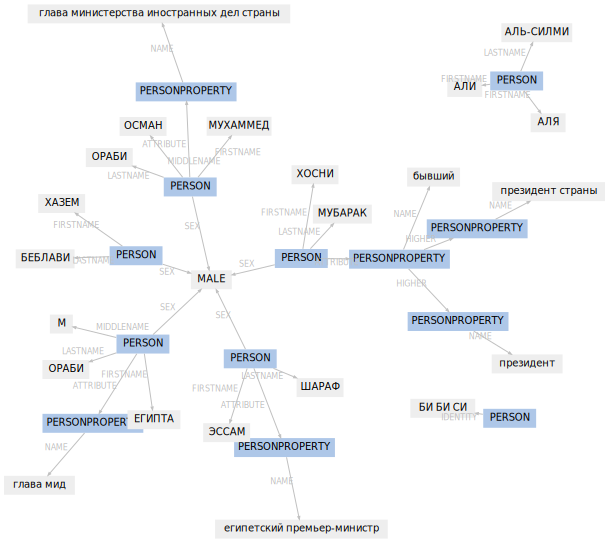

In [ ]:
result = ''
processor = Processor([PERSON])
ner_result = processor(test[0].text)
ner_result.graph

In [ ]:
aexact = 0
apartial = 0
amissing = 0
aspurius = 0
for sample in test:
    true_spans = sample.spans
    processor = Processor([PERSON])
    ner_result = processor(text)

    predicted_spans = []

    for match in ner_result.walk():
      start, stop = match.span
      label = match.referent.label
      if label == "PERSON":
        predicted_spans.append((start, stop, label[:-3]))

    exact, partial, missing, spurius = calc_metrics_spans_only(true_spans, predicted_spans)
    aexact += exact
    apartial += partial
    amissing += missing
    aspurius += spurius
print("Exact: {}, partial: {}, missing: {}, spurius: {}".format(aexact, apartial, amissing, aspurius))

Exact: 5, partial: 403, missing: 1071, spurius: 1990


Данная библиотека работает лучше, чем Polyglot, однако все равно результат хуже, чем у Natasha. Стоит отметить, что библиотека PullEnti гораздо удобнее в использовании, чем Polyglot, она имеет множество способов визуализации и позволяет получить дополнительную информацию о сущности, а именно пол, имя и фамилию человека.